# Multimodal Freight Transport Network Criticality Analysis - Examples
Bramka Arga Jafino

Delft University of Technology

Faculty of Technology, Policy and Management

## An introduction note

This notebook provides an example of a cradle-to-grave implementation of the transport network criticality analysis library, using Bangladesh freight transport network as the case study. Not all metrics are calculated in this notebook. Rather, only examples of several metrics are presented.

## 1. Import all required modules

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import networkx as nx
import pandas as pd
import geopandas as gp
from __future__ import division

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

#Modules developed for this project
from transport_network_modeling import network_prep as net_p
from transport_network_modeling import network_visualization as net_v
from transport_network_modeling import od_prep as od_p
from transport_network_modeling import criticality as crit

import datetime

startnow = datetime.datetime.now()

## 2. Network Preparation

Prepare GeoDataFrame of (i) all points in the road network (gdf_node_pos), (ii) location of all centroids (gdf_points), (iii) linestrings of all roads in the road network (gdf) 

In [2]:
network = r'./model_input_data/rmms_v11_7_waterway_noZ2.shp'
centroid = r'./model_input_data/BGD_Districtdata_Citycentroid_level2_v03.shp'

gdf_points, gdf_node_pos, gdf = net_p.prepare_centroids_network(centroid, network)

Reduce the cost to go through waterway

In [3]:
cost_reduction = 0.05
gdf['length'] = gdf.apply(lambda row: (row['length'] * (1 - cost_reduction) if row['mode']=='water' else row['length']), axis=1)

Create Networkx MultiGraph object from the GeoDataFrame

In [4]:
G2_new = net_p.gdf_to_simplified_multidigraph(gdf_node_pos, gdf)

Change the MultiGraph object to Graph object to reduce computation cost 

In [5]:
G2_new_tograph = net_p.multigraph_to_graph(G2_new)

Observe the properties of the Graph object

In [6]:
print('number of disconnected compoents is', nx.number_connected_components(G2_new_tograph))
nx.info(G2_new_tograph)

number of disconnected compoents is 3


'Name: \nType: Graph\nNumber of nodes: 966\nNumber of edges: 1260\nAverage degree:   2.6087'

Take only the largest subgraph

In [7]:
#take the largest components
for g in nx.connected_component_subgraphs(G2_new_tograph):
    if len(list(g.edges())) > 100:
        G3 = g
        
G2_new_tograph = G3.copy()

Save the simplified transport network back into GeoDataFrame

In [8]:
gdf2 = net_p.graph_to_df(G2_new_tograph)

Prepare the districts statistics for visualization later

In [9]:
adm_csv = r'./model_input_data/District_level_data_v7.csv'
adm_shp = r'./model_input_data/BGD_adm2.shp'

#Save the following information from csv to DataFrame
district_gdf2 = net_p.prepare_adm_background(adm_csv, adm_shp, ['Code', 'Population', 'Population_M', 'Total_export',
                                                               'Jute_mill', 'Flour_mill', 'Tot_Garment_Factory', 'Household',
                                                               'Land_throughput', 'SteelBricks_exp_ton', 'Food_exp_ton',
                                                               'Jutextile_exp_ton', 'Garment_exp_ton', 'Textile_loc_ton',
                                                               'Wheat_loc_ton', 'RawJute_loc_ton', 'Foods_loc_ton',
                                                               'Nonfoods_loc_ton'])

C:\Users\bjafino\anaconda3\lib\site-packages\pandas\core\frame.py:3778: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Embed the district data to centroids GeoDataFrame 

In [10]:
#read district data
district_data = pd.read_csv(adm_csv)

#rename to HASC_2
district_data.rename(columns={'Code':'HASC_2'}, inplace=True)

#merge them
gdf_points = pd.merge(gdf_points,district_data,on='HASC_2',how='outer')

Ensure that both dataframe have same crs

In [11]:
district_gdf2.crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}
gdf2.crs = {'proj': 'longlat', 'ellps': 'WGS84', 'datum': 'WGS84'}

## 3. Origin-Demand (OD) Matrix Preparation

Extract the Node ID of all centroid nodes (in this case the centroid nodes are the 64 districts in Bangladesh)

In [12]:
centroid_nodes = od_p.prepare_centroids_list(G2_new_tograph)

Prepare export-based OD

In [13]:
#list of production factors
prod_lists = ['Garment_exp_ton', 'Steel_exp_ton', 'Jute_exp_ton', 'Textile_exp_ton', 
              'Rice_exp_ton','Wheat_exp_ton', 'Fruits_exp_ton', 'Potatoes_exp_ton', 'Sugar_exp_ton', 'Bricks_exp_ton']

#attraction driver
attr_driver='Total_export'

#create the OD dictionary
OD_export_dict = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

OD_export = OD_export_dict[list(OD_export_dict.keys())[0]]
for i in range(len(OD_export_dict)-1):
    OD_export = OD_export +  OD_export_dict[list(OD_export_dict.keys())[i+1]]

Prepare local market based OD

In [14]:
#local trade OD    
    
#first for products which attraction is population
prod_lists = ['Garment_loc_ton', 'Steel_loc_ton','Jute_loc_ton',
              'Rice_loc_ton', 'Fruits_loc_ton', 'Potatoes_loc_ton', 'Sugar_loc_ton']
attr_driver='Population_x'
OD_local_dict1 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#next for raw jute
prod_lists = ['RawJute_loc_ton']
attr_driver='Jute_mill'
OD_local_dict2 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#next for wheat
prod_lists = ['Wheat_loc_ton']
attr_driver='Flour_mill'
OD_local_dict3 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#next for textile
prod_lists = ['Textile_loc_ton']
attr_driver='Tot_Garment_Factory'
OD_local_dict4 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

#last for bricks
prod_lists = ['Bricks_loc_ton']
attr_driver='Household'
OD_local_dict5 = od_p.all_ods_creation(gdf_points = gdf_points, prod_lists = prod_lists, attr_driver = attr_driver)

Combine all OD dictionaries into final OD Matrix

In [15]:
#Combine all local OD
OD_local1 = OD_local_dict1[list(OD_local_dict1.keys())[0]]
for i in range(len(OD_local_dict1)-1):
    OD_local1 = OD_local1 +  OD_local_dict1[list(OD_local_dict1.keys())[i+1]]
    
OD_local2 = OD_local_dict2[list(OD_local_dict2.keys())[0]]

OD_local3 = OD_local_dict3[list(OD_local_dict3.keys())[0]]

OD_local4 = OD_local_dict4[list(OD_local_dict4.keys())[0]]

OD_local5 = OD_local_dict5[list(OD_local_dict5.keys())[0]]

OD_local_all= OD_local1 + OD_local2 + OD_local3 + OD_local4 + OD_local5

In [16]:
#Create OD_all
OD_all = OD_local_all + OD_export

Create unweighted OD matrix for unweighted betweenness criticality analysis

In [17]:
centroid_district_listed = list(OD_all.columns)

OD_unweighted = pd.DataFrame(1, index=centroid_district_listed, columns=centroid_district_listed)

for i,row in OD_unweighted.iterrows():
    OD_unweighted.loc[i][i] = 0

Observe the OD Matrix in a graph

OD Heatmap for Division level


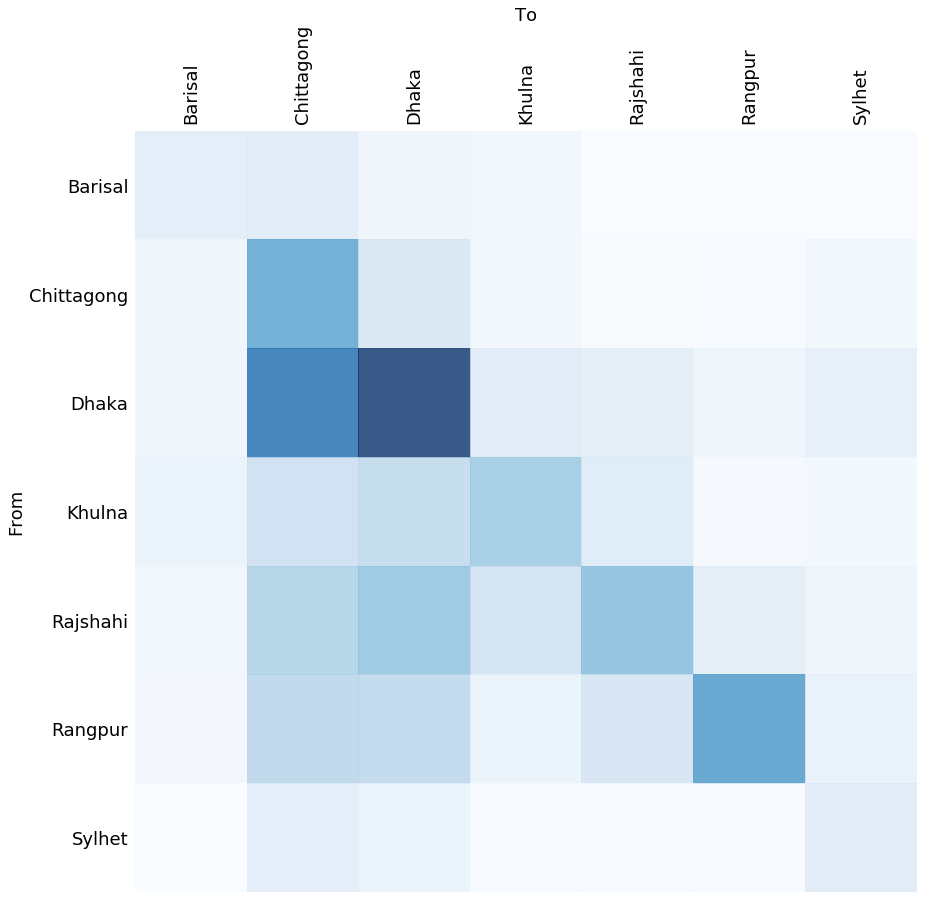

In [18]:
print('OD Heatmap for Division level')
net_v.plot_od_heatmap(OD_df = OD_all, gdf_points = gdf_points, division=True)

OD Heatmap for District level


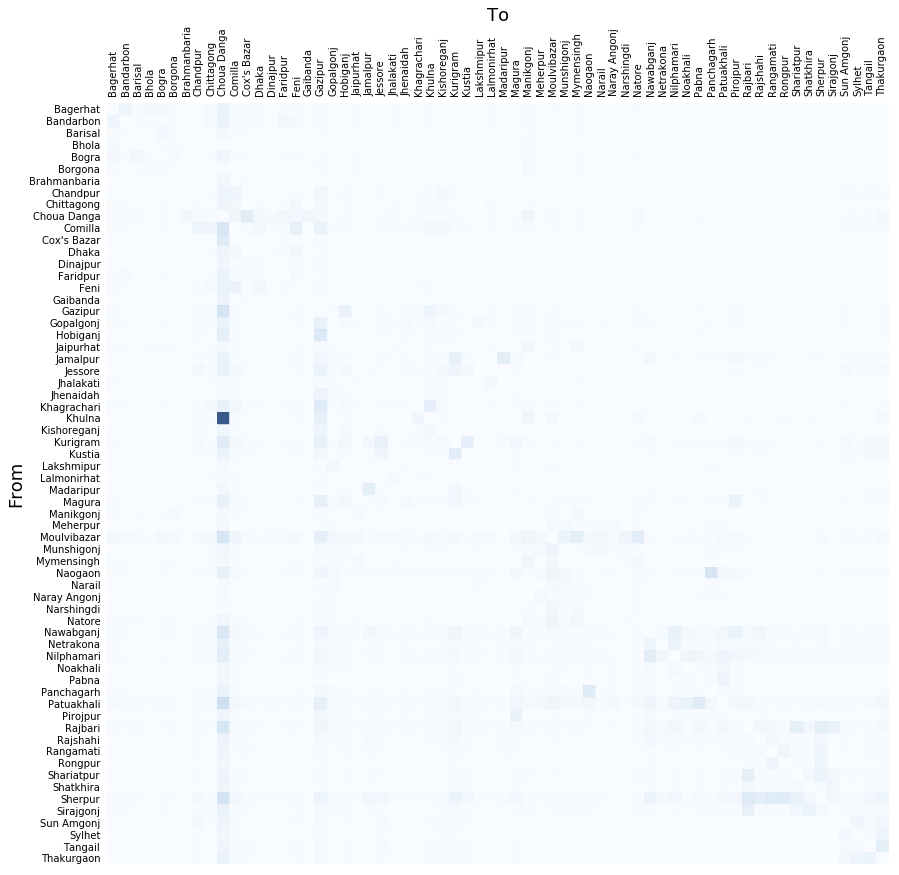

In [19]:
print('OD Heatmap for District level')
net_v.plot_od_heatmap(OD_df = OD_all, gdf_points = gdf_points)

OD Heatmap for District level, only for local market transportation activities


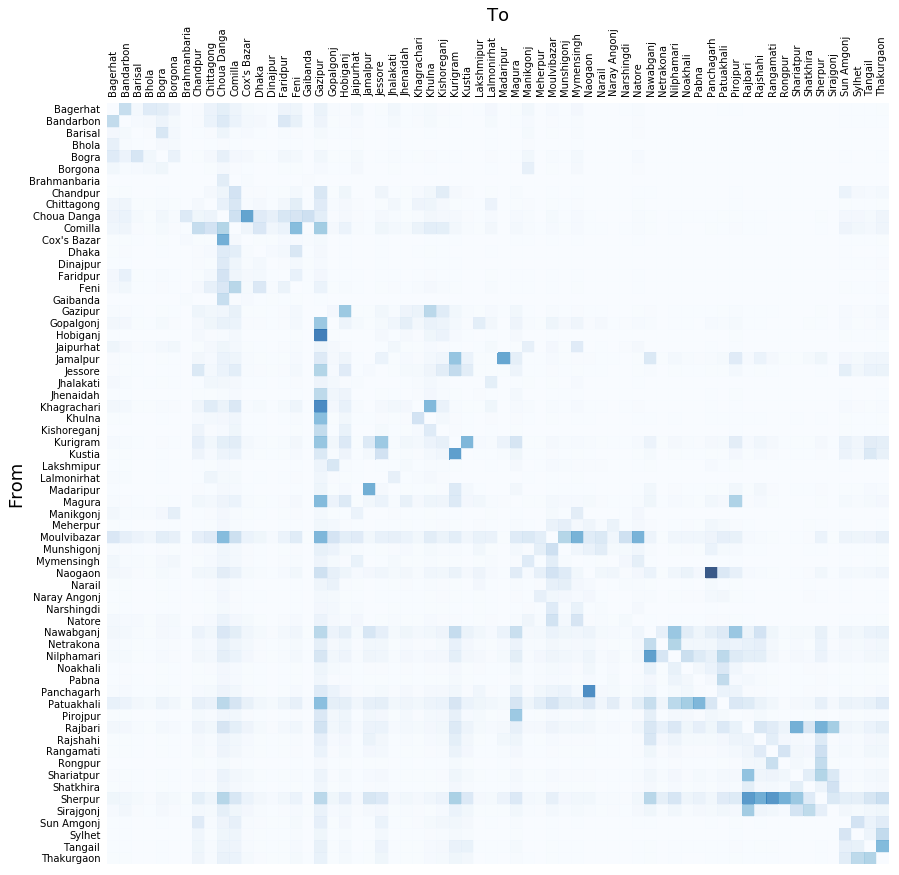

In [20]:
print('OD Heatmap for District level, only for local market transportation activities')
net_v.plot_od_heatmap(OD_df = OD_local_all, gdf_points = gdf_points)

## 4. Criticality analysis
Three criticality metrics are computed in this part:
1. Weighted betweenness criticality (M8_02 in the thesis report)
2. Unweighted betweenness criticality (M3_01 in the thesis report)
3. Minimum link cut criticality (M4_01 in the thesis report)

As in the visualization, the red links represent Bangladesh's road network while the blue links represent Bangladesh's waterway network.

### 4.1 Weighted betweenness criticality (M8_02)

In [21]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = crit.probit_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_all, N=5, penalty=1.1)

#calcualte betweenness centrality based on the flow assignment
betweenness_all_probit = crit.edge_betweenness_centrality(flow_probit_5, OD_all)

#save the betweenness centrality value into the original dataframe, for visualization purpose
gdf_final, betweenness_df = crit.betweenness_to_df(gdf2,betweenness_all_probit,'betweenness_all_probit')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_all_probit.values()))
print(e-c)

gdf_final, betweenness_df = crit.betweenness_to_df(gdf_final,flow_probit_5,'flow_probit_5')

12390765.590540472
0.20555485857386838
0:01:37.564918


Observe the modal split for validation purpose

In [22]:
total_water = gdf_final.loc[gdf_final['mode']=='water']['flow_probit_5'].sum()
total_road = gdf_final.loc[gdf_final['mode']=='road']['flow_probit_5'].sum()
total_flow = total_water + total_road
perc_water = 100 * total_water / total_flow
perc_road = 100 * total_road / total_flow
print('percentage by road is {} percent'.format(perc_road))
print('percentage by water is {} percent'.format(perc_water))

percentage by road is 85.06020428354512 percent
percentage by water is 14.939795716454869 percent


Visualize the result

Weighted link betweenness centrality (metric M8_02 in the main report)


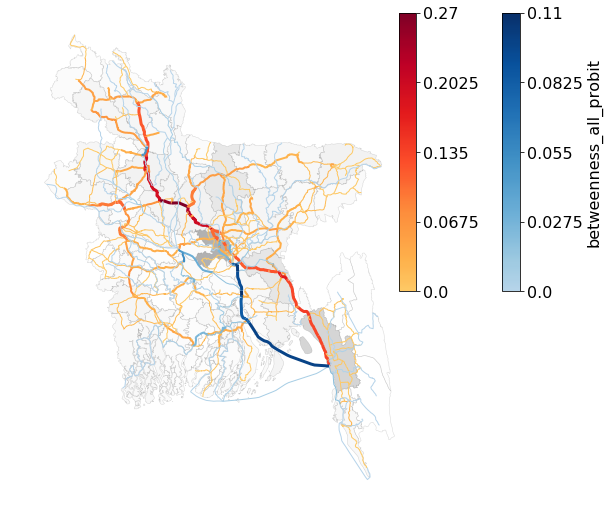

In [23]:
#create special colormap
cmap = plt.get_cmap('YlOrRd')
new_cmap1 = net_v.truncate_colormap(cmap, 0.3, 1)
cmap = plt.get_cmap('Blues')
new_cmap2 = net_v.truncate_colormap(cmap, 0.3, 1)

print('Weighted link betweenness centrality (metric M8_02 in the main report)')
net_v.plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_all_probit', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.27, 0.11],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

### 4.2 Unweighted betweenness criticality (M3_01)

In [24]:
import datetime
c = datetime.datetime.now()

#traffic flow assignment
flow_probit_5 = crit.aon_assignment(G=G2_new_tograph, sources=centroid_nodes, 
                                              targets=centroid_nodes, weight='length', od=OD_unweighted)

#calcualte betweenness centrality based on the flow assignment
betweenness_unweighted = crit.edge_betweenness_centrality(flow_probit_5, OD_unweighted)

#save the betweenness centrality value into the original dataframe, for visualization purpose
gdf_final, betweenness_df = crit.betweenness_to_df(gdf_final,betweenness_unweighted,'betweenness_unweighted')

e = datetime.datetime.now()
print(max(flow_probit_5.values()))
print(max(betweenness_unweighted.values()))
print(e-c)

1154.0
0.28621031746031744
0:00:17.096249


In [25]:
gdf_final, betweenness_df = crit.betweenness_to_df(gdf_final,flow_probit_5,'flow_probit_5')

Observe the modal split for validation purpose

In [26]:
total_water = gdf_final.loc[gdf_final['mode']=='water']['flow_probit_5_y'].sum()
total_road = gdf_final.loc[gdf_final['mode']=='road']['flow_probit_5_y'].sum()
total_flow = total_water + total_road
perc_water = 100 * total_water / total_flow
perc_road = 100 * total_road / total_flow
print('percentage by road is {} percent'.format(perc_road))
print('percentage by water is {} percent'.format(perc_water))

percentage by road is 88.8865169895028 percent
percentage by water is 11.113483010497202 percent


Visualize the result

Unweighted edge betweenness centrality (metric M3_01 in the main report)


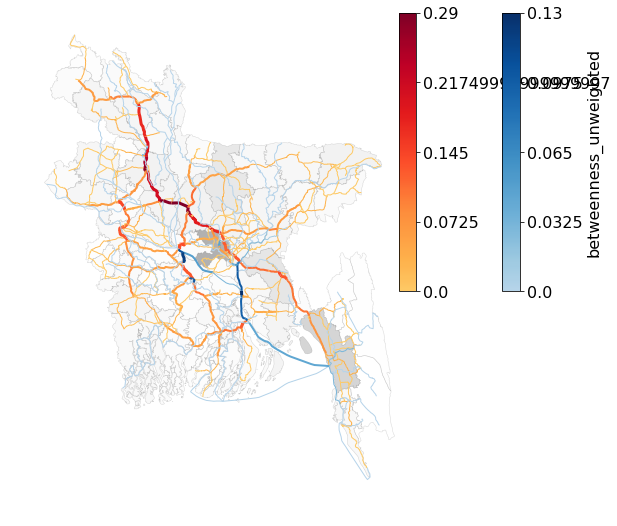

In [27]:
print('Unweighted edge betweenness centrality (metric M3_01 in the main report)')
net_v.plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='betweenness_unweighted', 
                        cmaps=[new_cmap1, new_cmap2], maxvals=[0.29, 0.13],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

### 4.3 Minimum link cut criticality (M4_01)

In [28]:
#calculate min cut criticality and save it into a dictionary
edgecut_dict = crit.min_edge_cut(G=G2_new_tograph, centroid_nodes=centroid_nodes)

In [29]:
#merge the dictionary to the original dataframe, for visualization purpose
gdf_final, betweenness_df = crit.betweenness_to_df(gdf_final,edgecut_dict,'Min_EdgeCut_Criticality')

Visualize the result

Minimum edge cut criticality (metric M4_01 in the main report)


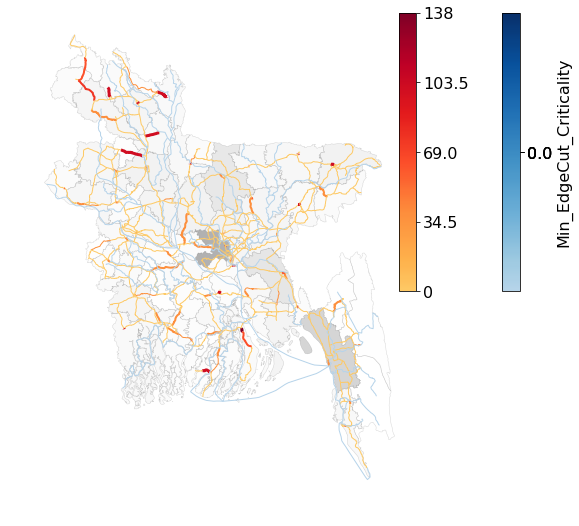

In [30]:
print('Minimum edge cut criticality (metric M4_01 in the main report)')
net_v.plot_network_multimodal(gdf=district_gdf2, gdf2=gdf_final, colname='Population_M',
                        betweenness_string='Min_EdgeCut_Criticality', 
                        cmaps=[new_cmap1, new_cmap2],
                        perc1=60, perc2=90,
                        modes=['road', 'water'])

In [31]:
endtime = datetime.datetime.now()

print(endtime-startnow)

0:07:34.723822
